# Rozpoznawanie gatunków kwiatów na podstawie obrazów

## Opis zbioru danych

W projekcie wykorzystano zbiór danych **🌸 | Flowers** dostępny na platformie Kaggle.
Zbiór zawiera obrazy przedstawiające 16 gatunków kwiatów.

Dane pochodzą z publicznego zbioru udostępnionego na platformie Kaggle:
https://www.kaggle.com/datasets/l3llff/flowers

Obrazy kwiatów są wykonane w różnych warunkach oświetleniowych i zróżnicowanych
tłach, co stanowi dodatkowe wyzwanie dla algorytmów klasyfikacji obrazów.

Projekt porównuje klasyczne metody uczenia maszynowego (SVM + HOG)
z podejściem opartym na sieciach konwolucyjnych (CNN).


#0. Pobranie danych

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("l3llff/flowers")

print("Path to dataset files:", path)

100%|██████████| 228M/228M [00:08<00:00, 28.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/l3llff/flowers/versions/4


In [7]:
!cd /root/.cache/kagglehub/datasets/l3llff/flowers

In [8]:
!ls

sample_data


In [10]:
import os
os.listdir(path + "/flowers")


['daffodil',
 'california_poppy',
 'sunflower',
 'water_lily',
 'dandelion',
 'carnation',
 'black_eyed_susan',
 'calendula',
 'rose',
 'common_daisy',
 'coreopsis',
 'iris',
 'magnolia',
 'bellflower',
 'tulip',
 'astilbe']

# 1. Eksploracja danych (EDA)

W tej części:
- sprawdzamy listę klas,
- liczymy liczbę obrazów w każdej klasie,
- wizualizujemy rozkład klas.

In [12]:
import os
from collections import Counter

DATA_DIR = path + '/flowers'

classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Liczba klas:", len(classes))
print("Klasy:", classes)

class_counts = {}
for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    class_counts[cls] = len(files)

class_counts


Liczba klas: 16
Klasy: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


{'astilbe': 737,
 'bellflower': 873,
 'black_eyed_susan': 1000,
 'calendula': 978,
 'california_poppy': 1022,
 'carnation': 923,
 'common_daisy': 980,
 'coreopsis': 1047,
 'daffodil': 970,
 'dandelion': 1052,
 'iris': 1054,
 'magnolia': 1048,
 'rose': 999,
 'sunflower': 1027,
 'tulip': 1048,
 'water_lily': 982}

### 1.1 Liczba obrazów w poszczególnych klasach

Poniższy wykres słupkowy przedstawia liczbę obrazów przypadających na każdą klasę kwiatów.
Pozwala on ocenić, czy zbiór danych jest zbalansowany.

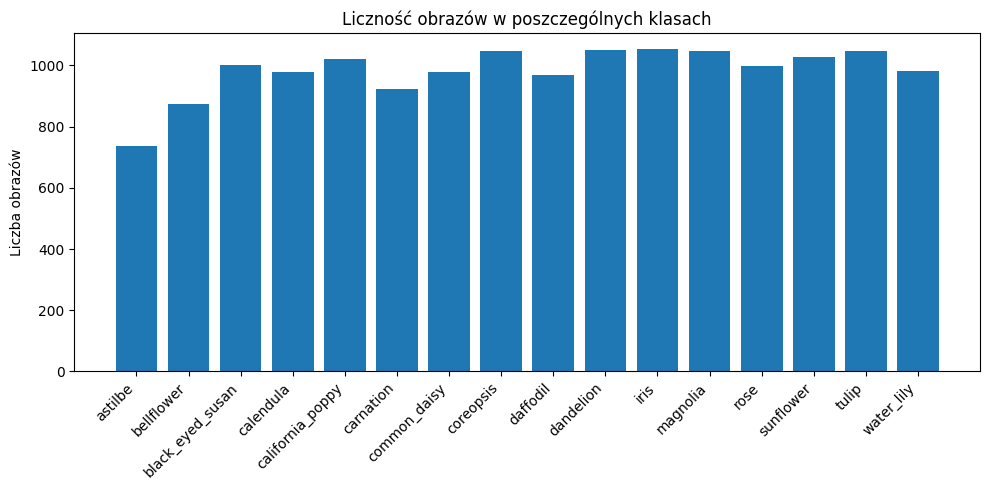

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Liczba obrazów")
plt.title("Liczność obrazów w poszczególnych klasach")
plt.tight_layout()
plt.show()

### 1.2 Przykładowe obrazy z każdej klasy

Poniżej przedstawiono po jednym przykładowym obrazie z każdej klasy kwiatów.


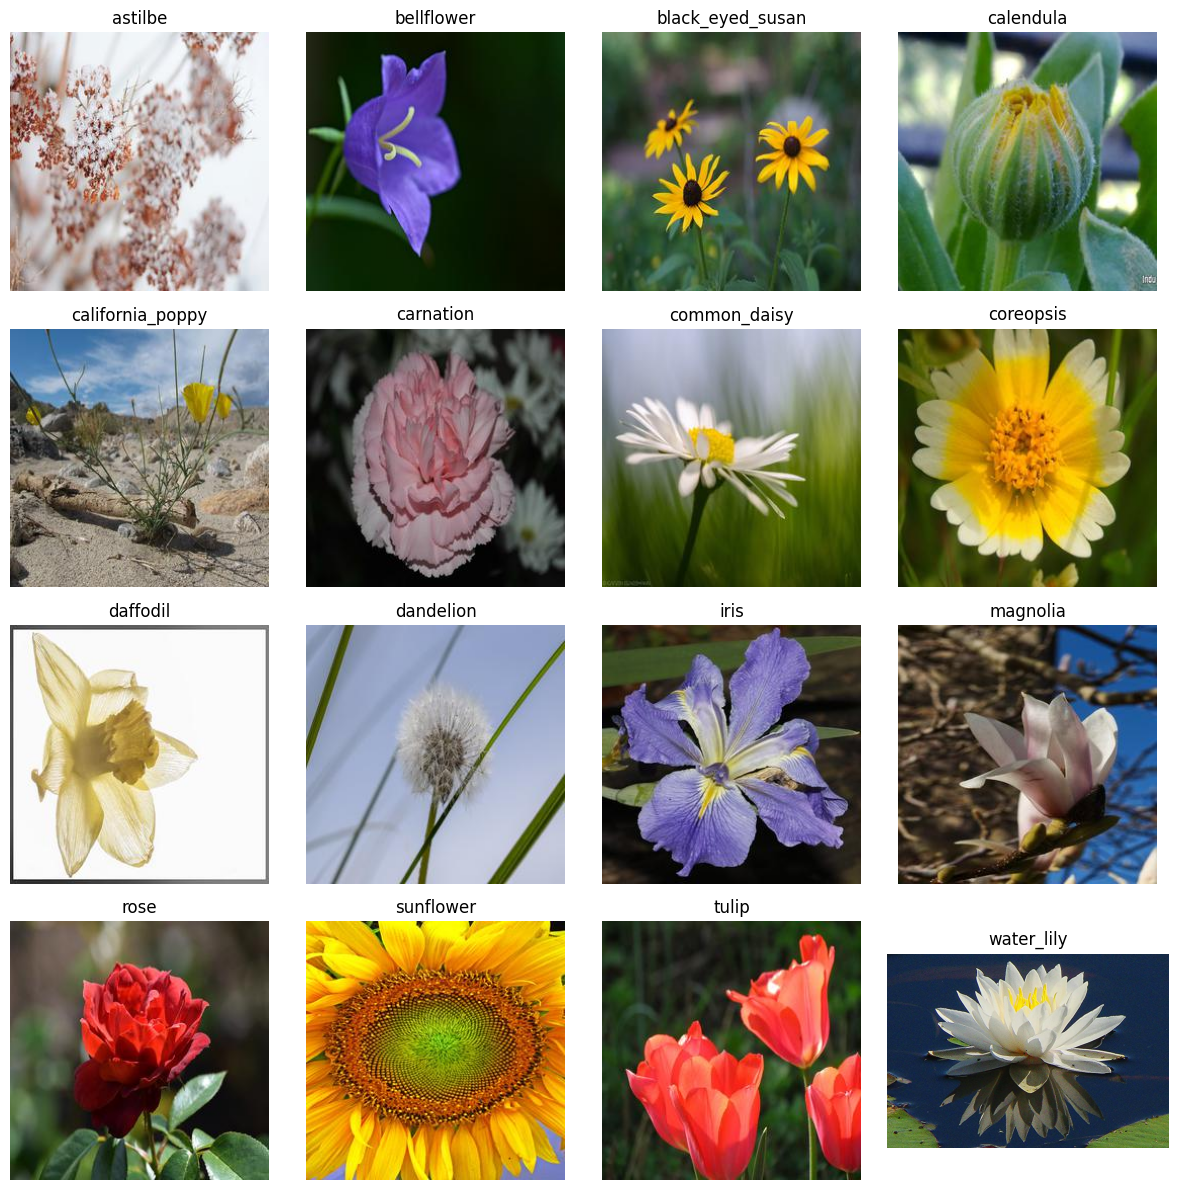

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

DATA_DIR = path + '/flowers'
classes = sorted(os.listdir(DATA_DIR))

n_classes = len(classes)
cols = 4
rows = (n_classes + cols - 1) // cols

plt.figure(figsize=(12, 3 * rows))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    img_name = random.choice(images)
    img_path = os.path.join(cls_dir, img_name)

    img = Image.open(img_path).convert("RGB")

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


### 1.3 Analiza rozdzielczości obrazów

W tej części analizowana jest rozdzielczość obrazów w zbiorze danych.
Celem jest sprawdzenie, czy obrazy mają jednorodne wymiary oraz
uzasadnienie konieczności przeskalowania (resize) przed trenowaniem modeli.

In [26]:
from PIL import Image
import os
import numpy as np

DATA_DIR = "/root/.cache/kagglehub/datasets/l3llff/flowers/versions/4/flowers"

widths = []
heights = []

for cls in os.listdir(DATA_DIR):
    cls_dir = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue

    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(cls_dir, fname)
            try:
                with Image.open(path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception:
                pass
print("Szerokość obrazów:")
print(f"  min: {np.min(widths)}")
print(f"  max: {np.max(widths)}")
print(f"  średnia: {np.mean(widths):.1f}")

print("\nWysokość obrazów:")
print(f"  min: {np.min(heights)}")
print(f"  max: {np.max(heights)}")
print(f"  średnia: {np.mean(heights):.1f}")


Szerokość obrazów:
  min: 256
  max: 800
  średnia: 288.8

Wysokość obrazów:
  min: 222
  max: 800
  średnia: 276.6


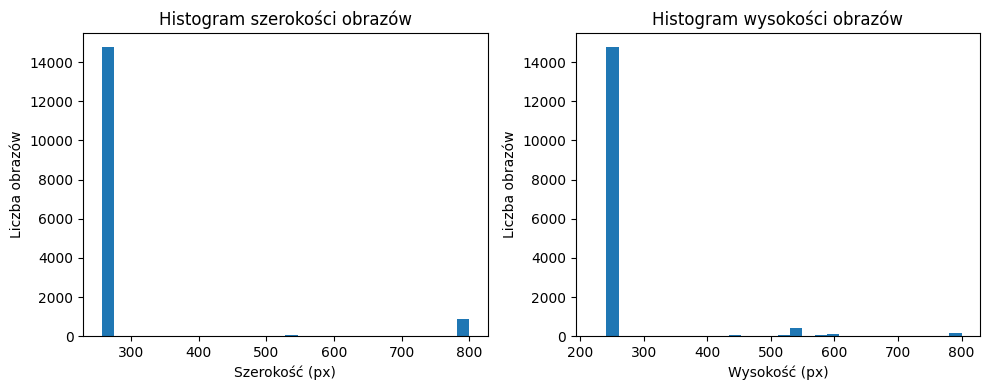

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.xlabel("Szerokość (px)")
plt.ylabel("Liczba obrazów")
plt.title("Histogram szerokości obrazów")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.xlabel("Wysokość (px)")
plt.ylabel("Liczba obrazów")
plt.title("Histogram wysokości obrazów")

plt.tight_layout()
plt.show()


**Wnioski:**

Chociaż większość obrazów posiada taką samą rozdzielczość, obecność
pojedynczych przykładów o znacznie większych wymiarach wymusza
zastosowanie przeskalowania obrazów do wspólnego formatu.


# 2. Przygotowanie danych

W tej części tworzę dwa warianty zbioru danych:
- **SVM (128×128)** – mniejszy rozmiar dla szybszej ekstrakcji cech i uczenia modeli klasycznych,
- **CNN (256×256)** – większy rozmiar zachowujący więcej szczegółów dla sieci konwolucyjnych.


In [6]:
import os
from PIL import Image
from tqdm.auto import tqdm

SRC_DIR = "/root/.cache/kagglehub/datasets/l3llff/flowers/versions/4/flowers"
OUT_BASE = "/content/processed"

SVM_DIR = os.path.join(OUT_BASE, "svm_128")
CNN_DIR = os.path.join(OUT_BASE, "cnn_256")

os.makedirs(SVM_DIR, exist_ok=True)
os.makedirs(CNN_DIR, exist_ok=True)

def prepare_resized_dataset(src_dir: str, dst_dir: str, size: int, overwrite: bool = False):
    classes = sorted([d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))])
    total = 0


    for cls in classes:
        cls_dir = os.path.join(src_dir, cls)
        total += sum(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in os.listdir(cls_dir))

    pbar = tqdm(total=total, desc=f"Resize -> {dst_dir} ({size}x{size})")

    for cls in classes:
        src_cls = os.path.join(src_dir, cls)
        dst_cls = os.path.join(dst_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)

        for fname in os.listdir(src_cls):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            src_path = os.path.join(src_cls, fname)

            base = os.path.splitext(fname)[0]
            dst_path = os.path.join(dst_cls, base + ".jpg")

            if (not overwrite) and os.path.exists(dst_path):
                pbar.update(1)
                continue

            try:
                with Image.open(src_path) as img:
                    img = img.convert("RGB")
                    img = img.resize((size, size), resample=Image.Resampling.LANCZOS)
                    img.save(dst_path, format="JPEG", quality=95)
            except Exception:

                pass

            pbar.update(1)

    pbar.close()


prepare_resized_dataset(SRC_DIR, SVM_DIR, size=128, overwrite=False)
prepare_resized_dataset(SRC_DIR, CNN_DIR, size=256, overwrite=False)

print("Gotowe.")
print("SVM dataset:", SVM_DIR)
print("CNN dataset:", CNN_DIR)


Resize -> /content/processed/svm_128 (128x128):   0%|          | 0/15740 [00:00<?, ?it/s]

Resize -> /content/processed/cnn_256 (256x256):   0%|          | 0/15740 [00:00<?, ?it/s]

Gotowe.
SVM dataset: /content/processed/svm_128
CNN dataset: /content/processed/cnn_256


### 2.1 Walidacja przygotowanych zbiorów

Sprawdzam:
- czy struktura folderów klas jest zachowana,
- czy liczba obrazów w każdej klasie jest taka sama w zbiorze źródłowym i po przeskalowaniu,
- czy przykładowe obrazy rzeczywiście mają docelowe rozdzielczości (128×128 i 256×256).


In [30]:
import os
from PIL import Image
import random

SRC_DIR = "/root/.cache/kagglehub/datasets/l3llff/flowers/versions/4/flowers"
SVM_DIR = "/content/processed/svm_128"
CNN_DIR = "/content/processed/cnn_256"

def count_images_per_class(root):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(root, cls)
        counts[cls] = sum(
            f.lower().endswith((".jpg", ".jpeg", ".png"))
            for f in os.listdir(cls_dir)
        )
    return counts

src_counts = count_images_per_class(SRC_DIR)
svm_counts = count_images_per_class(SVM_DIR)
cnn_counts = count_images_per_class(CNN_DIR)

classes = sorted(src_counts.keys())

# raport różnic
diffs = []
for cls in classes:
    a = src_counts.get(cls, 0)
    b = svm_counts.get(cls, 0)
    c = cnn_counts.get(cls, 0)
    if (a != b) or (a != c):
        diffs.append((cls, a, b, c))

print("Liczba klas (src/svm/cnn):", len(src_counts), len(svm_counts), len(cnn_counts))
print("Suma obrazów (src/svm/cnn):", sum(src_counts.values()), sum(svm_counts.values()), sum(cnn_counts.values()))

if not diffs:
    print("OK: liczba obrazów w każdej klasie zgadza się (src == svm == cnn).")
else:
    print("Uwaga: znaleziono różnice w liczebnościach dla klas:")
    for cls, a, b, c in diffs[:10]:
        print(f"  {cls}: src={a}, svm={b}, cnn={c}")
    if len(diffs) > 10:
        print(f"  ... oraz {len(diffs)-10} kolejnych")


Liczba klas (src/svm/cnn): 16 16 16
Suma obrazów (src/svm/cnn): 15740 15740 15740
OK: liczba obrazów w każdej klasie zgadza się (src == svm == cnn).


In [31]:
def sample_image_size(root, cls):
    cls_dir = os.path.join(root, cls)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not files:
        return None
    f = random.choice(files)
    path = os.path.join(cls_dir, f)
    with Image.open(path) as img:
        return img.size, path

cls = random.choice(classes)

src_size, src_path = sample_image_size(SRC_DIR, cls)
svm_size, svm_path = sample_image_size(SVM_DIR, cls)
cnn_size, cnn_path = sample_image_size(CNN_DIR, cls)

print("Losowa klasa:", cls)
print("SRC:", src_size, "-", src_path)
print("SVM:", svm_size, "-", svm_path)
print("CNN:", cnn_size, "-", cnn_path)


Losowa klasa: sunflower
SRC: (256, 256) - /root/.cache/kagglehub/datasets/l3llff/flowers/versions/4/flowers/sunflower/43280373770_2a77fd7117_c.jpg
SVM: (128, 128) - /content/processed/svm_128/sunflower/3799438180_dd1ffb535c_c.jpg
CNN: (256, 256) - /content/processed/cnn_256/sunflower/5470334361_bbd4cb832a_c.jpg


# 3. Model bazowy: SVM + cechy HOG
Ponieważ SVM nie operuje bezpośrednio na obrazach, najpierw zamieniam obrazy na wektory cech.
W tym rozdziale używam deskryptora **HOG (Histogram of Oriented Gradients)**, który opisuje krawędzie i lokalne gradienty,
a następnie uczę klasyfikator **SVM**.

Kroki:
1. Wczytanie obrazów 128×128.
2. Ekstrakcja cech HOG → macierz `X` oraz etykiety `y`.
3. Podział na zbiór treningowy i testowy.
4. Trening i ewaluacja SVM (accuracy + macierz pomyłek).


In [33]:
import os
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

from skimage.feature import hog

SVM_DIR = "/content/processed/svm_128"

HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    transform_sqrt=True,
    feature_vector=True
)

def load_hog_dataset(root_dir: str):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_idx = {c: i for i, c in enumerate(classes)}

    X, y = [], []

    all_files = []
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for f in os.listdir(cls_dir):
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                all_files.append((cls, os.path.join(cls_dir, f)))

    for cls, path in tqdm(all_files, desc="Ekstrakcja HOG"):
        try:
            with Image.open(path) as img:
                img = img.convert("L")
                arr = np.array(img)

            feat = hog(arr, **HOG_PARAMS)
            X.append(feat.astype(np.float32))
            y.append(class_to_idx[cls])
        except Exception:
            pass

    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int64)
    return X, y, classes

X, y, classes = load_hog_dataset(SVM_DIR)

print("X shape:", X.shape)  # (n_samples, n_features)
print("y shape:", y.shape)
print("Liczba klas:", len(classes))


Ekstrakcja HOG:   0%|          | 0/15740 [00:00<?, ?it/s]

X shape: (15740, 8100)
y shape: (15740,)
Liczba klas: 16


**Zamieniliśmy kolory wszystkich obrazów na odcienie szarości i wyliczyliśmy gradienty. Tam, gdzie gradient jest wysoki, zakładamy że jest krawędź. W ten sposób model nauczy się kształtu.**

### 3.1 Podział danych na zbiór treningowy i testowy

Dane po ekstrakcji cech HOG zostały podzielone na zbiór treningowy i testowy.
Zastosowano podział stratyfikowany, aby zachować proporcje klas w obu zbiorach.


In [34]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (12592, 8100) (12592,)
Test:  (3148, 8100) (3148,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=10, gamma="scale", random_state=42))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Accuracy: 0.41327827191867855

Raport klasyfikacji:
                  precision    recall  f1-score   support

         astilbe       0.40      0.53      0.45       147
      bellflower       0.18      0.13      0.15       175
black_eyed_susan       0.44      0.48      0.46       200
       calendula       0.31      0.24      0.27       196
california_poppy       0.31      0.33      0.32       204
       carnation       0.32      0.35      0.34       185
    common_daisy       0.25      0.18      0.21       196
       coreopsis       0.37      0.32      0.34       209
        daffodil       0.49      0.50      0.49       194
       dandelion       0.60      0.52      0.56       210
            iris       0.48      0.43      0.45       211
        magnolia       0.27      0.25      0.26       210
            rose       0.58      0.62      0.60       200
       sunflower       0.60      0.60      0.60       205
           tulip       0.45      0.55      0.50       210
      water_lily   

<Figure size 1000x1000 with 0 Axes>

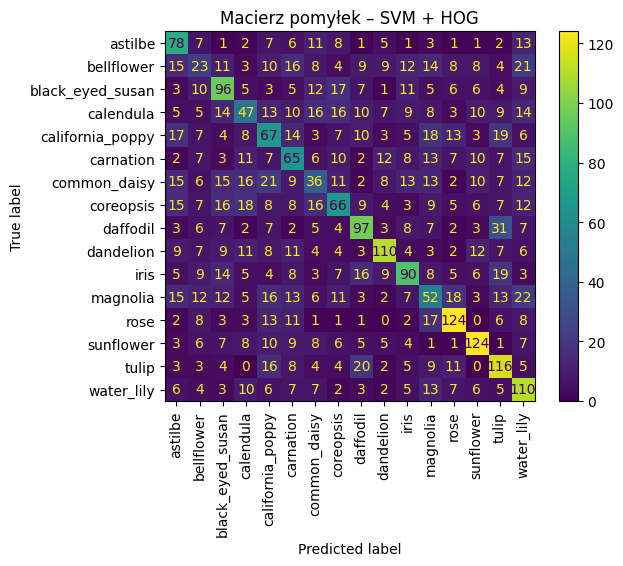

In [44]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=90, cmap=None)
plt.title("Macierz pomyłek – SVM + HOG")
plt.show()

Model SVM z cechami HOG osiągnął dokładność na poziomie około 41%. <br>Przy 16 klasach, losowy model miałby skuteczność: <br>$$\frac{1}{16} \approx 6\%$$
<br>
Najlepsze wyniki uzyskano dla klas o wyraźnie charakterystycznym kształcie,
takich jak *sunflower* czy *rose*. <br>Model często mylił natomiast klasy o podobnej
strukturze płatków, co wskazuje na ograniczenia ręcznie projektowanych cech
opartych wyłącznie na krawędziach.
<br>Wyniki te stanowią punkt odniesienia dla
dalszych eksperymentów z sieciami konwolucyjnymi.
<br><br><small>Model ten uczył się ok. 35 min.</small>

# 4. Klasyfikacja obrazów z użyciem sieci konwolucyjnych (CNN)

W przeciwieństwie do metod klasycznych (HOG + SVM), sieci konwolucyjne uczą się
reprezentacji cech automatycznie bez ręcznego projektowania deskryptorów.
W tym rozdziale wykorzystuję sieć CNN do klasyfikacji obrazów kwiatów.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices("GPU")
print("GPU dostępne:", gpus)


TensorFlow version: 2.19.0
GPU dostępne: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
CNN_DIR = "/content/processed/cnn_256"

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 42

train_ds = keras.utils.image_dataset_from_directory(
    CNN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = keras.utils.image_dataset_from_directory(
    CNN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Liczba klas:", num_classes)
print("Klasy:", class_names)


Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.
Liczba klas: 16
Klasy: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### 4.1 Prosty model CNN

Buduję niewielką sieć konwolucyjną jako baseline dla podejścia deep learning.
Model zawiera:
- normalizację wejścia,
- kilka bloków Conv2D + MaxPooling,
- warstwy Dense na końcu.

Celem jest uzyskanie punktu odniesienia przed transfer learningiem.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(train_ds.class_names)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

model = keras.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Rescaling(1./255),
    data_augmentation,

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,376 (1.62 MB)

 Trainable params: 423,376 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Zastosowano augmentację danych polegającą na losowych przekształceniach obrazów
(takich jak obrót, odbicie oraz zmiana skali), co pozwala zwiększyć różnorodność
danych treningowych bez fizycznego powielania zbioru.

### 4.2 Kompilacja i trening

Używam funkcji straty `SparseCategoricalCrossentropy`, ponieważ etykiety są liczbami całkowitymi.
Dodatkowo stosuję `EarlyStopping` oraz `ReduceLROnPlateau`, aby ograniczyć przeuczenie i skrócić trening.


In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - accuracy: 0.1881 - loss: 2.3497 - val_accuracy: 0.3987 - val_loss: 1.7432 - learning_rate: 0.0010
Epoch 2/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.3625 - loss: 1.8244 - val_accuracy: 0.4825 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.4210 - loss: 1.6606 - val_accuracy: 0.4828 - val_loss: 1.5239 - learning_rate: 0.0010
Epoch 4/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.4632 - loss: 1.5676 - val_accuracy: 0.5213 - val_loss: 1.4132 - learning_rate: 0.0010
Epoch 5/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.4925 - loss: 1.4972 - val_accuracy: 0.5635 - val_loss: 1.2941 - learning_rate: 0.0010
Epoch 6/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.5125 - loss: 1.4304 - val_accuracy: 0.5832 - val_loss: 1.2448 - learning_rate: 0.0010
Epoch 7/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.5

Nasz model sieci konwolucyjnej z augmentacją osiągnął dokładność:<br>
$$ accuracy \approx 70\% , $$<br>
$$ validationAccuracy \approx 74\% $$<br>
, co jest dobrym wynikiem. Następnym krokiem będzie wykorzystanie transfer learningu.

## 4.3 Transfer learning (EfficientNetB0)

Wykorzystamy bazową sieć EfficientNetB0
wstępnie wytrenowaną na ImageNet. Najpierw zamrażamy warstwy bazy i uczymy tylko
klasyfikator na końcu (tzw. head). Następnie wykonamy fine-tuning, odmrażając
część ostatnich warstw sieci bazowej.


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (256, 256)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # zamrożenie

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)  # ważne dla EfficientNet
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

tl_model = keras.Model(inputs, outputs)

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        20,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,070,067 (15.53 MB)

 Trainable params: 20,496 (80.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

###Trening klasyfikatora

W pierwszym etapie uczę tylko warstwę klasyfikującą, a wagi sieci bazowej pozostają stałe.


In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

history_tl = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 0.6210 - loss: 1.3955 - val_accuracy: 0.8993 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.8861 - loss: 0.4373 - val_accuracy: 0.9155 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 82s 121ms/step - accuracy: 0.9019 - loss: 0.3413 - val_accuracy: 0.9238 - val_loss: 0.2616 - learning_rate: 0.0010
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.9165 - loss: 0.2954 - val_accuracy: 0.9234 - val_loss: 0.2508 - learning_rate: 0.0010
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.9196 - loss: 0.2673 - val_accuracy: 0.9285 - val_loss: 0.2325 - learning_rate: 0.0010
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.9248 - loss: 0.2529 - val_accuracy: 0.9320 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.9

###Fine-tuning

W drugim etapie odmrażam część ostatnich warstw EfficientNetB0 i kontynuuję trening
z mniejszym współczynnikiem uczenia (learning rate), aby delikatnie dostroić model do danych.


In [10]:
base_model.trainable = True

# Zamrażamy większość, odmrażamy tylko końcówkę
fine_tune_at = len(base_model.layers) - 30  # ~ostatnie 30 warstw
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_ft = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.8520 - loss: 0.4855 - val_accuracy: 0.9180 - val_loss: 0.2712 - learning_rate: 1.0000e-05
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.8911 - loss: 0.3673 - val_accuracy: 0.9273 - val_loss: 0.2398 - learning_rate: 1.0000e-05
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.9102 - loss: 0.2934 - val_accuracy: 0.9339 - val_loss: 0.2211 - learning_rate: 1.0000e-05
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - accuracy: 0.9225 - loss: 0.2642 - val_accuracy: 0.9390 - val_loss: 0.2081 - learning_rate: 1.0000e-05
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.9327 - loss: 0.2292 - val_accuracy: 0.9393 - val_loss: 0.1994 - learning_rate: 1.0000e-05
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.9302 - loss: 0.2259 - val_accuracy: 0.9419 - val_loss: 0.1930 - learning_rate: 1.0000e-05
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 55s 14

Zastosowanie transfer learningu z wykorzystaniem EfficientNetB0 pozwoliło
uzyskać dokładność na poziomie około 94% na zbiorze walidacyjnym, co stanowi
znaczną poprawę w porównaniu z modelem klasycznym (HOG + SVM) oraz prostą
siecią CNN trenowaną od zera.
